This notebook is loosely based on the Tangram [tutorial](tutorial_tangram_without_squidpy.ipynb) provided in the master repostiory. Working with [this](https://github.com/almaan/Tangram/tree/almaan) branch

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import tangram as tg
from functools import reduce

## Data

### Load data

In [3]:
SPATIAL_PTH = '../data/tls_nsclc/cosmx/NSCLC_8_blocks_with_meta_negprbQC_filter20.h5ad'
FLEX_PTH = '../data/tls_nsclc/flex/LuCA_Flex_scANVI_refined_v4.h5ad'

In [4]:
# load single cell data (reference)
ad_sc = sc.read_h5ad(FLEX_PTH)
ad_sc

AnnData object with n_obs × n_vars = 25968 × 18082
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mito', 'modality', 'celltype_hint', 'Cell Types', 'Sample_ID', 'Cancer_subtype', 'S_score', 'G2M_score', 'phase', 'Reference_labels_with_mitotic', 'Reference_labels_no_mitotic'
    var: 'gene_ids', 'feature_types', 'genome', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'neighbors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
# load spatial data
ad_sp = sc.read_h5ad(SPATIAL_PTH)
ad_sp

AnnData object with n_obs × n_vars = 853288 × 990
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD20', 'Max.CD20', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'block', 'NegPrb_mean', 'NegPrb_sum', 'path_fov', 'Pathology_Number', 'H&E_FOVnum', 'SMI_FOVnum', 'Alignment confidence', 'Lymphoid structure 1', 'Lymphoid structure 2', 'TISSUE', 'TILS', 'MIBI Prediction and Notes', 'Lymphoid structure 1 mid-range aggregate', 'Lymphoid structure 1 LA aggregate', 'Lymphoid structure 1 LA/Dense + RSL aggregates', 'Lymphoid structure 1 with MIBI pred', 'Lymphoid structure 1 with MIBI pred, OOLA agg.', 'Cancer_subtype'
    var: 'NegPrb'
    uns: 'log1p'
    obsm: 'spatial', 'spatial_fov'
    layers: 'all_tx', 'cytoplasm_tx', 'membrane_tx', 'minus_mean_negprb', 'nuclear_tx'

Set variables (e.g., column names etc.)

In [6]:
sample_col_sp = 'block'
sample_col_sc_raw = 'Sample_ID'
sample_col_sc = 'Sample_ID_curated'
labels_sc = 'Reference_labels_with_mitotic'

Next step is dataset specific, we harmonize labels etc. to make sure we can match certain attributes

In [7]:
# Dataset specific (harmonize single cell and spatial data)
fix_col_fun = lambda x: x.replace('HP','HP-') # set to 'x' if no changes are needed
ad_sc.obs[sample_col_sc] = list(map(fix_col_fun,ad_sc.obs[sample_col_sc_raw].values))

# get sample ids that are present in both samples
inter_samples = np.array(list(set(ad_sc.obs[sample_col_sc].values).intersection(set(ad_sp.obs[sample_col_sp].values))))

# only keep cells that are from the same patients as in the spatial data
keep_sp = np.isin(ad_sp.obs[sample_col_sp].values, inter_samples)
keep_sc = np.isin(ad_sc.obs[sample_col_sc].values, inter_samples)

ad_sp = ad_sp[keep_sp]
ad_sc = ad_sc[keep_sc]

Subset data to only work with a single sample (speeds things up)

In [8]:
subset_val = 'HP-61307'
is_subset_sp = ad_sp.obs[sample_col_sp].values == subset_val
is_subset_sc = ad_sc.obs[sample_col_sc].values == subset_val
print('#spatial {}/{} | #sc {}/{}'.format( sum(is_subset_sp), len(is_subset_sp), sum(is_subset_sc),len(is_subset_sc)))

ad_sp = ad_sp[is_subset_sp]
ad_sc = ad_sc[is_subset_sc]

#spatial 100278/598390 | #sc 5030/25968


Next step is dataset specific as well, but we'll rename some `.obsm` objects to make plotting easier

In [9]:
ad_sp.obsm['_spatial'] = ad_sp.obsm.pop('spatial')
ad_sp.obsm['spatial'] = ad_sp.obsm.pop('spatial_fov')

visualize the spatial data, color by FOV. This is just a sanity check.

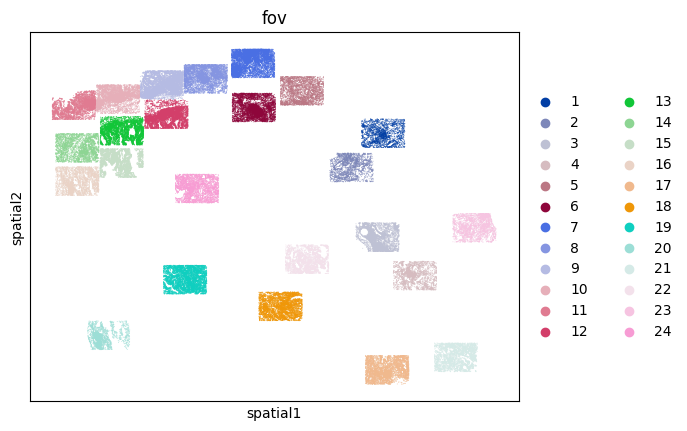

In [10]:
sc.pl.spatial(ad_sp,spot_size = 100, color = ['fov'])

## Processing
We process the data as to prepare it for the actual analysis. This step is dataset specific.


The spatial data is already processed (by Bob Chen), the recipie he used is described (by him) as:
> Count matrices contained are as follows:
> * .raw.X = raw counts from all 1009 features, includes NegPrbs (note that raw layer is different size than adata due to this)
> * .layers[‘all_tx’] = raw counts for 990 features, genes only, sum of cytoplasm_tx, membrane_tx, and nuclear_tx
> * .layers[‘minus_mean_negprb’] = all_tx layer minus mean of NegPrb counts per cell, clipped at 0, 990 features
> * .X = minus_mean_negprb layer, normalized to total of 1e4 then log1p transformed, 990 features

The sc data is not processed, so we'll have to do some simple qc, we begin with removal of potentially bad cells

In [11]:
# process spatial data
None

In [12]:
# process single cell data

# scanpy doesn't do min_counts and min_genes at the same time, doing them sequentially could lead to dropping of acutally ok cells
min_counts = 100
min_genes = 20
keep_sc_cells = (np.array(ad_sc.X.sum(axis=1)).flatten() >= min_counts) * ( np.array( (ad_sc.X != 0).sum(axis=1)).flatten() >= min_genes)
print('keeping {}/{}'.format(sum(keep_sc_cells),len(ad_sc)))
ad_sc = ad_sc[keep_sc_cells]

# standard normalization
sc.pp.normalize_total(ad_sc,1e4)
sc.pp.log1p(ad_sc)

keeping 5030/5030


Next, inspect the  different labels found in the signle cell data

In [13]:
ad_sc.obs[labels_sc].value_counts()

Reference_labels_with_mitotic
Transitional club/AT2      650
Plasma cell                605
Tumor cells LuAD           489
Fibroblast                 472
B cell                     442
Alveolar cell type 2       363
Macrophage                 340
Tumor cells NSCLC mixed    325
T cell CD4                 253
Endothelial cell           199
cDC2                       171
Monocyte                   117
Alveolar cell type 1       108
Macrophage alveolar         94
T cell NK-like              84
Tumor cells LuSC            68
Pericyte                    55
Mesothelial                 28
T cell CD8                  27
Ciliated                    25
DC mature                   23
Lymphatic endothelial       21
pDC                         13
Mast cell                   11
T cell CD4 mitotic          10
Smooth muscle cell           8
Club                         8
T cell CD8 mitotic           6
NK cell                      5
cDC1                         5
Plasma cell mitotic          2
B cell mi

***
#### Map data using Tangram

We'll map to a single field of view, the cell below selects that FOV

In [14]:
fov_col = 'fov'
fov_sel_value = '5'
is_fov = ad_sp.obs[fov_col].values == fov_sel_value
fov_adata = ad_sp[is_fov].copy()

We need to select a set of training genes to present to `tangram`, we will also leave one out to demonstrate the prediction capability

In [15]:
np.random.seed(42)
train_set = list(set(list(ad_sp.var.index.unique())).intersection(set(ad_sc.var.index.unique())))
left_out_feature = train_set.pop(np.random.choice(len(train_set)))
print(f'#[training genes] : {len(train_set)} | left out feature : {left_out_feature}')

#[training genes] : 937 | left out feature : CD27


Preprocess data using `tangram`'s`pp` function

In [16]:
tg.pp_adatas(ad_sc, fov_adata, genes=train_set)

INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Perform the actual mapping

In [17]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=fov_adata,
    mode = 'cells', #default
    device='cuda:0',
    num_epochs = 10,
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133


INFO:root:Saving results..


#### Inspect results / Downstream analysis

To **qualitatively** evvaluate the mapping performed by `tangram` we can inspect the predicted cell type distributions

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


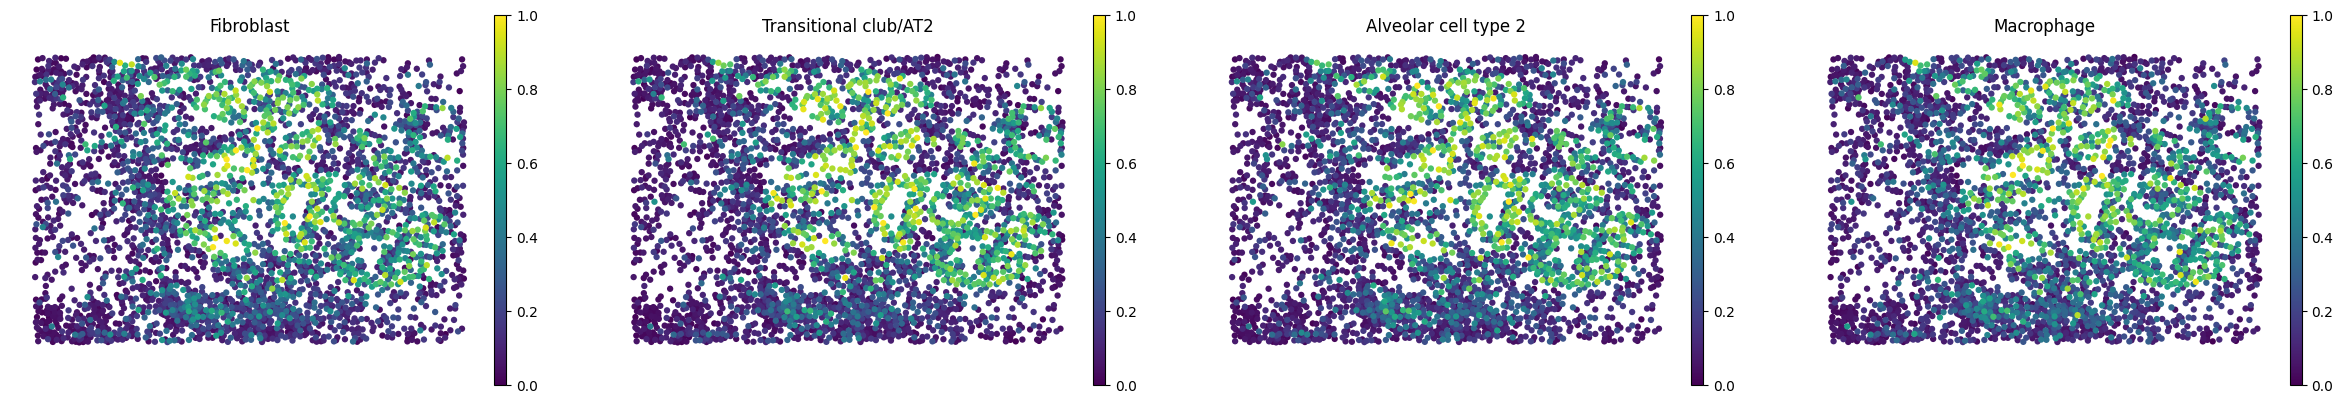

In [18]:
# project annotations
tg.project_cell_annotations(ad_map, fov_adata, annotation=labels_sc)

# for plotting, we want coordinates stored in `.obs`
fov_adata.obs['x'] = fov_adata.obsm['spatial'][:,0]
fov_adata.obs['y'] = fov_adata.obsm['spatial'][:,1]
# annotations to plot, we'll only look at a few
annotation_list = list(pd.unique(ad_sc.obs[labels_sc].values))[0:4]

tg.plot_cell_annotation_sc(fov_adata, annotation_list,x='x', y='y',spot_size= 80, scale_factor=0.1, perc=0.001)

More **quantitatively** we can also inspect the training scores

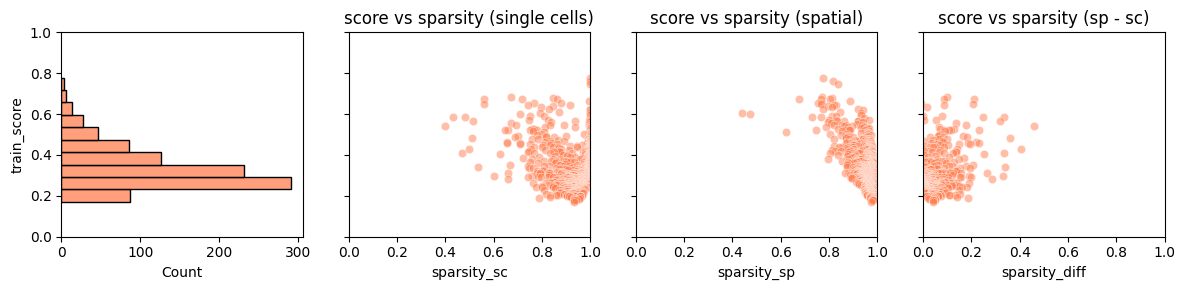

In [19]:
tg.plot_training_scores(ad_map, bins=10, alpha=.5)

- Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores.
- These information can be access from the dataframe `.uns['train_genes_df']` from the mapping results; this is the dataframe used to build the four plots above.

Predict gene expression of all genes (found in the reference)

In [20]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

AnnData object with n_obs × n_vars = 3439 × 17272
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD20', 'Max.CD20', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'block', 'NegPrb_mean', 'NegPrb_sum', 'path_fov', 'Pathology_Number', 'H&E_FOVnum', 'SMI_FOVnum', 'Alignment confidence', 'Lymphoid structure 1', 'Lymphoid structure 2', 'TISSUE', 'TILS', 'MIBI Prediction and Notes', 'Lymphoid structure 1 mid-range aggregate', 'Lymphoid structure 1 LA aggregate', 'Lymphoid structure 1 LA/Dense + RSL aggregates', 'Lymphoid structure 1 with MIBI pred', 'Lymphoid structure 1 with MIBI pred, OOLA agg.', 'Cancer_subtype', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'feature_types', 'genome', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'sparsity

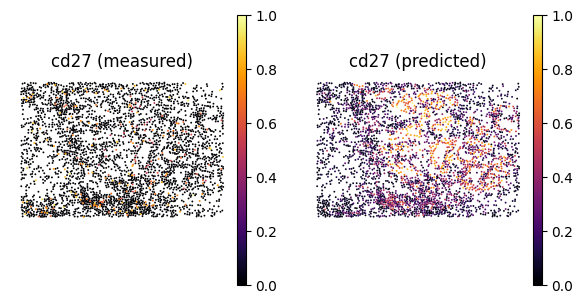

In [21]:
tg.plot_genes_sc(left_out_feature,
                 adata_measured=fov_adata,
                 adata_predicted=ad_ge,
                 spot_size=50,
                 scale_factor=0.1,
                 perc = 0.001,
                 return_figure=False,
                 lower_gene_names=True,
                )

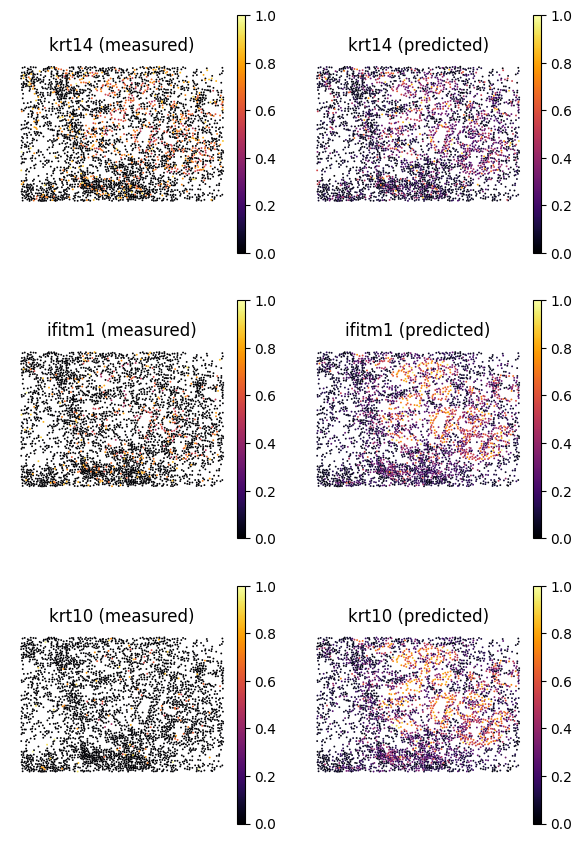

In [22]:
tg.plot_genes_sc(train_set[0:3],
                 adata_measured=fov_adata,
                 adata_predicted=ad_ge,
                 spot_size=50,
                 scale_factor=0.1,
                 perc = 0.001,
                 return_figure=False,
                 lower_gene_names = True,
                )

### LOO validation (manual)

Here we will do a leave one out validation, there is a `tangram` function for this but we'll implement it from scratch

In [23]:
# helper functions
def cosine_similarity(v1,v2):
    norm_sq = np.linalg.norm(v1) * np.linalg.norm(v2)
    return (v1 @ v2) / norm_sq

def split_list(l,pos):
    if pos == 0:
        return l[1::],l[0]
    elif pos == len(l):
        return l[0:-1],l[-1]
    else:
        l_pos = l[pos]
        l_rest = l[0:pos] + l[pos+1:]
        return l_rest,l_pos

Below is the actual LOOV workflow

In [30]:
# the set of genes that are present in both spatial and reference data
full_set = list(set(fov_adata.var.index.unique().tolist()).intersection(ad_sc.var.index.unique().tolist()))

# set number of genes to test (set to len(full_set) or None to test all genes)
num_tests = 50
num_tests = (len(full_set) if num_tests is None else num_tests)


cs_list_tg = []
cs_list_bg = []

# loop over each test marker
for k,test_marker in enumerate(full_set):
    print('GENE : {}  | {}/{}'.format(test_marker,k+1,num_tests,))
    if num_tests is not None and k >= num_tests: break

    # train_set contains all genes in full set excluding the test_marker one
    train_set,_ = split_list(full_set,k)

    # prep data
    tg.pp_adatas(ad_sc, fov_adata, genes=train_set)

    # map data
    _ad_map = tg.map_cells_to_space(
        adata_sc=ad_sc,
        adata_sp=fov_adata,
        mode = 'cells',
        device='cuda:0',
        num_epochs = 500,
    )

    pred_x = _ad_map.X.T @ ad_sc.obs_vector(test_marker)
    true_x = fov_adata.obs_vector(test_marker)
    mean_x = fov_adata.to_df()[train_set].values.mean(axis=1)

    cs_tg = cosine_similarity(pred_x,true_x)
    cs_bg = cosine_similarity(mean_x,true_x)
    
    cs_list_tg.append(cs_tg)
    cs_list_bg.append(cs_bg)


GENE : icam3  | 1/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : itm2a  | 2/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : rxrb  | 3/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : lrrc15  | 4/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : cxcl13  | 5/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : krt17  | 6/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : il12rb2  | 7/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : egf  | 8/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : fgfr2  | 9/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ccl23  | 10/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : btg1  | 11/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : krt23  | 12/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : lgals3bp  | 13/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ccl15  | 14/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : tnfsf14  | 15/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : plac8  | 16/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : col1a1  | 17/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ier3  | 18/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : cd14  | 19/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ccl20  | 20/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : stat1  | 21/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : adm2  | 22/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : alcam  | 23/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : klf2  | 24/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : dhrs2  | 25/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.684, KL reg: 0.001
Score: 0.685, KL reg: 0.001


INFO:root:Saving results..


GENE : b2m  | 26/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : adgrl4  | 27/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : zfp36  | 28/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ddr2  | 29/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : wnt7a  | 30/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : xcl2  | 31/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : igkc  | 32/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ephb4  | 33/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : gpbar1  | 34/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : fgr  | 35/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : ddit3  | 36/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : nrg4  | 37/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : bmp6  | 38/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : dst  | 39/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : oxer1  | 40/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : efna1  | 41/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.134
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : emp3  | 42/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : cd81  | 43/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : c1qa  | 44/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : cd44  | 45/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : nkg7  | 46/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : lamp3  | 47/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : itga6  | 48/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : slc2a4  | 49/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.673, KL reg: 0.001
Score: 0.682, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : myc  | 50/50


INFO:root:921 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 921 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.214, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..


GENE : clec5a  | 51/50


visualize the results

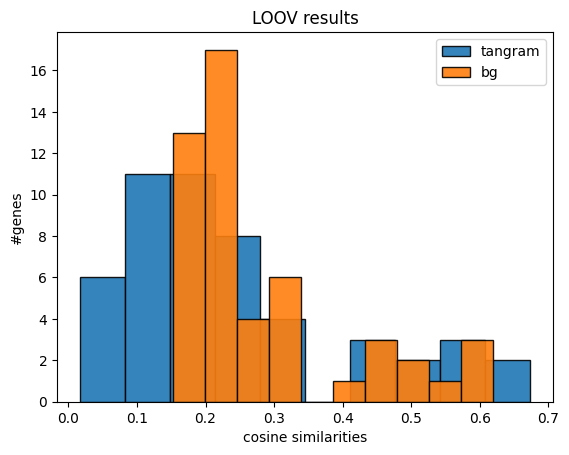

In [40]:
plt.title('LOOV results')
plt.hist(cs_list_tg, label = 'tangram', edgecolor = 'black',alpha = 0.9)
plt.hist(cs_list_bg, label = 'bg', edgecolor = 'black', alpha = 0.9)
plt.legend()
plt.xlabel('cosine similarities')
plt.ylabel('#genes')
plt.show()

**Note**: The "background" (bg) is the cosine similarity for a gene's expression and the mean expression across all other spatial genes

### Leave out for gene modules

Just leaving one gene out doesn’t quite correct for highly correlated genes (e.g., genes being found in the same gene expression module (e.g., factor)). We’ll use a slightly different approach to test for this. First, let’s identify a set of ‘gene expression modules’ (a.k.a. factors) using NMF. Genes in the same expression modules can be considered as co-expressed. 

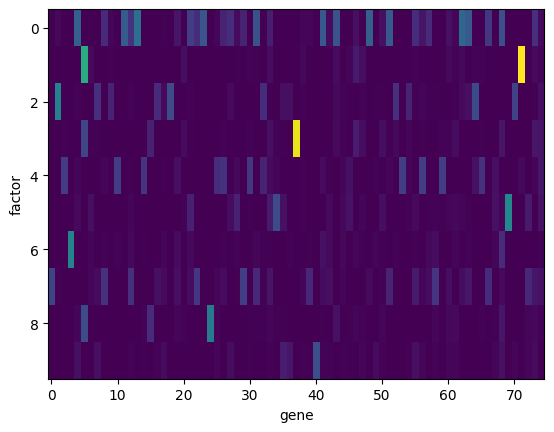

In [26]:
# identify and get unique factor genes

from sklearn.decomposition import NMF

# we use ten factors
nmf = NMF(n_components=10)
# use the top_k genes with highest factor association (for each factor)
top_k = 10

# only use overlapping genes to fit NMF
inter_genes = np.array(list(full_set))
nmf.fit(fov_adata.to_df()[inter_genes].values)
# get factor weights for each gene
W = nmf.components_.copy()
ordr = np.argsort(W,axis = 1)[:,::-1][:,0:top_k]
factor_idxs = {k:ordr[k] for k in range(W.shape[0])}

# only keep genes that are unique to a factor
idxs,counts = np.unique(ordr,return_counts = True)
drop_idxs = idxs[counts > 1]

factor_names = {k:inter_genes[idx[~np.isin(idx,drop_idxs)]].tolist() for k,idx in factor_idxs.items()}

plt.imshow(W[:,idxs])
plt.axis('auto')
plt.xlabel('gene')
plt.ylabel('factor')
plt.show()

The plot above shows the weights for the the total set of genes (across all factors). Most genes have high weights in one factor only (genes are a factor specific). A bad factorization would have resulted in vertical lines (gene has high association with multiple factors). 

In [27]:
# helper function for cosine similarities
def mat_cosine_similarity(V1,V2, axis = 1):
    norms_sq = np.linalg.norm(V1, axis = axis,keepdims = True) * np.linalg.norm(V2,axis=axis,keepdims = True)
    ewise = V1 * V2
    dot_unorm = np.sum(ewise,axis =axis)
    cs = dot_unorm / norms_sq.flatten()
    return cs
        

We exclude the genes associated with each model and use _all_ other genes to try and predict them

In [28]:
cs_factor = dict()

for test_module_name,test_module_genes in factor_names.items():

    train_set =  list( set(full_set).difference(set(test_module_genes)) )
    
    tg.pp_adatas(ad_sc, fov_adata, genes=train_set)
    
    _ad_map = tg.map_cells_to_space(
        adata_sc=ad_sc,
        adata_sp=fov_adata,
        mode = 'cells',
        device='cuda:0',
        num_epochs = 500,
    )

    pred_x = _ad_map.X.T @ ad_sc.to_df()[test_module_genes].values
    true_x = fov_adata.to_df()[test_module_genes].values

    cs_vec = mat_cosine_similarity(pred_x,true_x, axis = 0)
    
    
    cs_factor[test_module_name] = cs_vec


INFO:root:915 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 915 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.212, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..
INFO:root:918 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 918 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.686, KL reg: 0.001
Score: 0.687, KL reg: 0.001


INFO:root:Saving results..
INFO:root:913 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 913 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.212, KL reg: 0.133
Score: 0.676, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.687, KL reg: 0.001
Score: 0.688, KL reg: 0.001


INFO:root:Saving results..
INFO:root:920 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 920 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..
INFO:root:912 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 912 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.212, KL reg: 0.133
Score: 0.676, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.687, KL reg: 0.001
Score: 0.688, KL reg: 0.001


INFO:root:Saving results..
INFO:root:917 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 917 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.675, KL reg: 0.001
Score: 0.684, KL reg: 0.001
Score: 0.687, KL reg: 0.001
Score: 0.688, KL reg: 0.001


INFO:root:Saving results..
INFO:root:917 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 917 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.675, KL reg: 0.001
Score: 0.684, KL reg: 0.001
Score: 0.686, KL reg: 0.001
Score: 0.687, KL reg: 0.001


INFO:root:Saving results..
INFO:root:915 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 915 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.212, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.683, KL reg: 0.001
Score: 0.685, KL reg: 0.001
Score: 0.686, KL reg: 0.001


INFO:root:Saving results..
INFO:root:919 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 919 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.674, KL reg: 0.001
Score: 0.684, KL reg: 0.001
Score: 0.686, KL reg: 0.001
Score: 0.687, KL reg: 0.001


INFO:root:Saving results..
INFO:root:916 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:922 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 916 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.213, KL reg: 0.133
Score: 0.675, KL reg: 0.001
Score: 0.684, KL reg: 0.001
Score: 0.686, KL reg: 0.001
Score: 0.687, KL reg: 0.001


INFO:root:Saving results..


Inspect the results

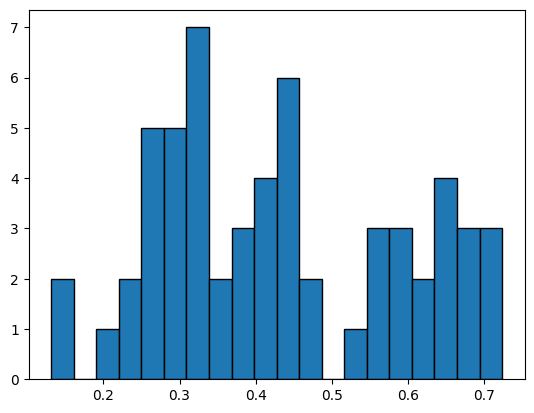

In [29]:
all_cs_values = reduce( lambda x,y : x + y,  [v.tolist() for v in cs_factor.values()])

plt.hist(all_cs_values,
         bins = 20,
         edgecolor = 'black',
        )

plt.show()